Célula para importação

In [34]:
from pyspark.sql.functions import sum, avg, count, when, col, std, format_number, year, month, day, desc, asc, cast,mean, expr
from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.types import IntegerType, StringType, DoubleType, TimestampType, FloatType, LongType
import pandas as pd
import numpy as np
import statistics as st
import matplotlib as plt
import seaborn as sns
import os

Célula para pegar o caminho raiz do arquivo

In [8]:
#Pega a pasta atual em que o arquivo se encontra
RAIZ: str = os.getcwd()
#Junta o caminho raiz com o arquivo desejado
BASE_DIR: str = os.path.join(RAIZ, 'Retail_Transaction.xlsx')
#Importa o arquivo, como é CSV é necessário separar por vírgula

Inicialização do Pyspark junto com a importação do arquivo com pandas para mais na frente converter para spark

In [9]:
# Criar uma SparkSession
spark: SparkSession = SparkSession.builder \
    .appName("Consumo") \
    .getOrCreate()
# Ler dados de um arquivo excel
df: pd.DataFrame  = pd.read_excel(BASE_DIR, sheet_name='Sheet1')

Formatação prévia das datas devido a problemas que podem acontecer no futuro 

In [10]:
# transforma o dataframe em uma lista devido a problemas comimpor formatação
transacao_datas: list[str] | list[list[str]] = list(df['TransactionDate'])
# separa os valores das datas
for index, datas in enumerate(transacao_datas):
    transacao_datas[index]: list[str] | str = datas.split("/")
# caso a data ou mês só tenha 1 digito, adiciona um 0 na frfente
for index, datas in enumerate(transacao_datas):
    for internal_index, valor in enumerate(datas):
        if len(valor) < 2:
            transacao_datas[index][internal_index] : str = f"0{valor}"
# junta as datas
for index, datas in enumerate(transacao_datas):
    transacao_datas[index]: list[str] | str = "/".join(datas)
# transforma as datas em uma coluna dataframe
df_datas = pd.DataFrame({"TransactionDate": transacao_datas})
# atribui as datas a coluna do datrame
df['TransactionDate'] = df_datas
# converte as datas pra datetime
df['TransactionDate'] = pd.to_datetime(df.TransactionDate)

Inspeção Inicial de dados

In [11]:
# Converte um dataframe pandas para um dataframe spark
Transaction: DataFrame = spark.createDataFrame(df)
# Mostrar os primeiros registros do DataFrame
Transaction.show(5)

# Mostrar o esquema do DataFrame
Transaction.printSchema()

+----------+----------+---------+--------+-----------+-------------------+-------------+--------------------+---------------+------------------+-----------+
|Unnamed: 0|CustomerID|ProductID|Quantity|      Price|    TransactionDate|PaymentMethod|       StoreLocation|ProductCategory|DiscountApplied(%)|TotalAmount|
+----------+----------+---------+--------+-----------+-------------------+-------------+--------------------+---------------+------------------+-----------+
|         0|    109318|        C|       7|80.07984415|2023-12-26 12:32:00|         Cash|176 Andrew Cliffs...|          Books|        18.6770995|455.8627638|
|         1|    993229|        C|       4|75.19522942|2023-08-05 00:00:00|         Cash|11635 William Wel...|     Home Decor|       14.12136502|258.3065464|
|         2|    579675|        A|       8|31.52881648|2024-03-11 18:51:00|         Cash|910 Mendez Ville ...|          Books|       15.94370066|212.0156509|
|         3|    799826|        D|       5|98.88021828|2023

Limpeza e Tratamento de dados

In [13]:
# Contar valores nulos por coluna
Transaction.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()
# Remover linhas com qualquer valor nulo
Transaction_Clean: DataFrame = Transaction.dropna()
# Remove duplicados
Transaction_Clean: DataFrame = Transaction_Clean.dropDuplicates()
# Filtrar linhas com quantidade ou preço negativos
Transaction_Clean: DataFrame = Transaction_Clean.filter((Transaction_Clean["Quantity"] > 0) & (Transaction_Clean["Price"] > 0) & (Transaction_Clean["DiscountApplied(%)"] >= 0))
# formata as colunas que possuem números reais para possuir no máximo 2 casas decimais e também converte o tipo das determinadas columas para número real
Transaction_Clean: DataFrame = (Transaction_Clean.withColumn("Price", col("Price").cast("float")).withColumn("Price", format_number(Transaction_Clean["Price"], 2))
                                .withColumn("DiscountApplied(%)", col("DiscountApplied(%)").cast("float")).withColumn("DiscountApplied(%)", format_number(Transaction_Clean["DiscountApplied(%)"], 2))
                                .withColumn("TotalAmount", col("TotalAmount").cast("float")).withColumn("TotalAmount", format_number(Transaction_Clean["TotalAmount"], 2)))

+----------+----------+---------+--------+-----+---------------+-------------+-------------+---------------+------------------+-----------+
|Unnamed: 0|CustomerID|ProductID|Quantity|Price|TransactionDate|PaymentMethod|StoreLocation|ProductCategory|DiscountApplied(%)|TotalAmount|
+----------+----------+---------+--------+-----+---------------+-------------+-------------+---------------+------------------+-----------+
|         0|         0|        0|       0|    0|              0|            0|            0|              0|                 0|          0|
+----------+----------+---------+--------+-----+---------------+-------------+-------------+---------------+------------------+-----------+



AnalysisException: [MISSING_ATTRIBUTES.RESOLVED_ATTRIBUTE_APPEAR_IN_OPERATION] Resolved attribute(s) "Price" missing from "Unnamed: 0", "CustomerID", "ProductID", "Quantity", "Price", "TransactionDate", "PaymentMethod", "StoreLocation", "ProductCategory", "DiscountApplied(%)", "TotalAmount" in operator !Project [Unnamed: 0#0L, CustomerID#1L, ProductID#2, Quantity#3L, format_number(Price#4, 2) AS Price#323, TransactionDate#5, PaymentMethod#6, StoreLocation#7, ProductCategory#8, DiscountApplied(%)#9, TotalAmount#10]. Attribute(s) with the same name appear in the operation: "Price".
Please check if the right attribute(s) are used.;
!Project [Unnamed: 0#0L, CustomerID#1L, ProductID#2, Quantity#3L, format_number(Price#4, 2) AS Price#323, TransactionDate#5, PaymentMethod#6, StoreLocation#7, ProductCategory#8, DiscountApplied(%)#9, TotalAmount#10]
+- Project [Unnamed: 0#0L, CustomerID#1L, ProductID#2, Quantity#3L, cast(Price#4 as float) AS Price#311, TransactionDate#5, PaymentMethod#6, StoreLocation#7, ProductCategory#8, DiscountApplied(%)#9, TotalAmount#10]
   +- Filter (((Quantity#3L > cast(0 as bigint)) AND (Price#4 > cast(0 as double))) AND (DiscountApplied(%)#9 >= cast(0 as double)))
      +- Deduplicate [Quantity#3L, TotalAmount#10, CustomerID#1L, Price#4, StoreLocation#7, ProductCategory#8, Unnamed: 0#0L, TransactionDate#5, ProductID#2, PaymentMethod#6, DiscountApplied(%)#9]
         +- Filter atleastnnonnulls(11, Unnamed: 0#0L, CustomerID#1L, ProductID#2, Quantity#3L, Price#4, TransactionDate#5, PaymentMethod#6, StoreLocation#7, ProductCategory#8, DiscountApplied(%)#9, TotalAmount#10)
            +- LogicalRDD [Unnamed: 0#0L, CustomerID#1L, ProductID#2, Quantity#3L, Price#4, TransactionDate#5, PaymentMethod#6, StoreLocation#7, ProductCategory#8, DiscountApplied(%)#9, TotalAmount#10], false


In [14]:
Transaction_Clean.show()
Transaction_Clean.printSchema()

+----------+----------+---------+--------+-----------+-------------------+-------------+--------------------+---------------+------------------+-----------+
|Unnamed: 0|CustomerID|ProductID|Quantity|      Price|    TransactionDate|PaymentMethod|       StoreLocation|ProductCategory|DiscountApplied(%)|TotalAmount|
+----------+----------+---------+--------+-----------+-------------------+-------------+--------------------+---------------+------------------+-----------+
|       517|    768027|        D|       1|81.75612284|2023-07-26 21:59:00|         Cash|644 Patel River\n...|          Books|       15.86988478|68.78152035|
|       535|    608285|        B|       6|59.68429524|2023-09-29 06:46:00|  Credit Card|1002 Dawn Plain A...|    Electronics|        7.63302201|330.7714791|
|      1163|    744100|        A|       1|31.94335812|2024-03-11 16:00:00|       PayPal|23849 Adriana Lod...|     Home Decor|       16.59913828|26.64103593|
|      1324|    459092|        D|       7| 10.0488432|2023

Calcular o total de vendas por categoria de produto

In [15]:
Transaction_Agrupado: DataFrame = Transaction_Clean.groupBy("ProductCategory").agg(sum("TotalAmount").alias("TotalSales"))
Transaction_Agrupado.show()

+---------------+-----------------+
|ProductCategory|       TotalSales|
+---------------+-----------------+
|    Electronics|6196734.758744199|
|       Clothing|6205502.348754664|
|          Books|6257837.043115519|
|     Home Decor|6173421.355771133|
+---------------+-----------------+



Calcular a média de descontos aplicados por método de pagamento

In [16]:
Transaction_Descontos = Transaction_Clean.groupBy("PaymentMethod").agg(avg("DiscountApplied(%)").alias("AverageDiscount"))
Transaction_Descontos.show()

+-------------+------------------+
|PaymentMethod|   AverageDiscount|
+-------------+------------------+
|  Credit Card| 10.03116308028181|
|       PayPal|10.008327592227264|
|         Cash| 10.03301790466662|
|   Debit Card|10.008069497067055|
+-------------+------------------+



In [17]:
# Adicionar colunas de ano e mês
Transaction_Clean = Transaction_Clean.withColumn("Year", year("TransactionDate"))
Transaction_Clean = Transaction_Clean.withColumn("Month", month("TransactionDate"))
Transaction_Clean = Transaction_Clean.withColumn("Day", day("TransactionDate"))
# Calcular vendas mensais
Transaction_venda_diaria = Transaction_Clean.groupBy("Month", "Day").agg(sum("TotalAmount").alias("DailySales")).orderBy(desc("DailySales"))
Transaction_venda_diaria.show()

+-----+---+-----------------+
|Month|Day|       DailySales|
+-----+---+-----------------+
|   12|  1|   83049.51594861|
|    1| 13|82985.01451571201|
|   10|  3|81782.03127321001|
|    6| 29|   81664.26111011|
|    1| 30|   80351.40598898|
|    6|  5|80277.38514937699|
|    7| 18|79690.51131472999|
|    4|  4|   79028.52027835|
|    1| 16|   78970.38160429|
|   11|  2|   78764.65648014|
|    7| 31|   78526.23379413|
|    9| 28|   78272.38116167|
|    3| 15|  77828.184627962|
|   11| 16|  77583.698018286|
|    3|  5|77546.98296815001|
|    9| 22|   77512.96266329|
|    8| 24|   77381.52466296|
|    3| 25|77144.85874866002|
|    7|  8|  77083.971073889|
|    5| 25|76727.28133312998|
+-----+---+-----------------+
only showing top 20 rows



In [18]:
Transaction_venda_mensal = Transaction_Clean.groupBy("Year", "Month").agg(sum("TotalAmount").alias("MonthlySales")).orderBy(desc("MonthlySales"))
Transaction_venda_mensal.show()

+----+-----+------------------+
|Year|Month|      MonthlySales|
+----+-----+------------------+
|2023|    7| 2132550.517749446|
|2024|    1|2128345.2769411867|
|2023|   12|2125651.0656809583|
|2023|    8| 2109352.646045025|
|2024|    3| 2108248.042126509|
|2023|    5|2099576.1008348833|
|2023|    6|2066364.8233160693|
|2023|   11| 2051277.297132632|
|2023|    9|2050334.6010149356|
|2023|   10|2049450.6981157311|
|2024|    2|1973154.1172272428|
|2024|    4|1878349.5323468787|
|2023|    4|   60840.787854022|
+----+-----+------------------+



In [19]:
numeric_cols: list = []
categorical_cols: list = []

Transaction_schema = Transaction_Clean.schema
# Separar colunas com base no tipo de dado
for field in Transaction_schema:
    if isinstance(field.dataType, (IntegerType, DoubleType, FloatType, LongType)):
        numeric_cols.append(field.name)
    elif isinstance(field.dataType, (StringType, TimestampType)):
        categorical_cols.append(field.name)

numeric_cols.remove('Unnamed: 0')
numeric_cols.remove("CustomerID")
Transaction_numerico = Transaction_Clean.select(numeric_cols)
Transaction_categorico = Transaction_Clean.select(categorical_cols)

In [20]:
def calcula_outlier(dataframe: DataFrame, col_name: str) -> tuple:
    q1 = dataframe.approxQuantile(col_name, [0.25], 0.01)[0]
    q3 = dataframe.approxQuantile(col_name, [0.75], 0.01)[0]
    iqr = q3 - q1
    outliers_inferior = q1 - 1.5 * iqr
    outliers_superior = q3 + 1.5 * iqr
    return outliers_inferior, outliers_superior

# Calcular os limites para cada coluna numérica
outliers_limite = {col_name: calcula_outlier(Transaction_numerico, col_name) for col_name in numeric_cols}
print(outliers_limite)

{'Quantity': (-3.0, 13.0), 'Price': (-34.145917880000006, 143.66259860000002), 'DiscountApplied(%)': (-9.8155356225, 29.6791015975), 'TotalAmount': (-299.96853877499996, 750.2632981449999), 'Year': (2021.5, 2025.5), 'Month': (-6.0, 18.0), 'Day': (-14.5, 45.5)}


In [21]:
# Função para identificar outliers
def identifica_outlier(dataframe: DataFrame, col_name: str, outliers_inferiores: float, outliers_superiores: float) -> DataFrame:
    return dataframe.filter((col(col_name) < outliers_inferiores) | (col(col_name) > outliers_superiores))

# Identificar e mostrar os outliers
outliers = {}
for col_name, (outlier_inferior, outlier_superior) in outliers_limite.items():
    transaction_outlier = identifica_outlier(Transaction_numerico, col_name, outlier_inferior, outlier_superior)
    outliers[col_name] = transaction_outlier

# Mostrar os outliers para cada coluna
for col_name, transaction_outlier in outliers.items():
    print(f"Outliers na coluna {col_name}:")
    transaction_outlier.show()

Outliers na coluna Quantity:
+--------+-----+------------------+-----------+----+-----+---+
|Quantity|Price|DiscountApplied(%)|TotalAmount|Year|Month|Day|
+--------+-----+------------------+-----------+----+-----+---+
+--------+-----+------------------+-----------+----+-----+---+

Outliers na coluna Price:
+--------+-----+------------------+-----------+----+-----+---+
|Quantity|Price|DiscountApplied(%)|TotalAmount|Year|Month|Day|
+--------+-----+------------------+-----------+----+-----+---+
+--------+-----+------------------+-----------+----+-----+---+

Outliers na coluna DiscountApplied(%):
+--------+-----+------------------+-----------+----+-----+---+
|Quantity|Price|DiscountApplied(%)|TotalAmount|Year|Month|Day|
+--------+-----+------------------+-----------+----+-----+---+
+--------+-----+------------------+-----------+----+-----+---+

Outliers na coluna TotalAmount:
+--------+-----------+------------------+-----------+----+-----+---+
|Quantity|      Price|DiscountApplied(%)|Total

In [31]:
os.makedirs(os.path.join(RAIZ,"Relatórios"), exist_ok=True)
CAMINHO_PARA_SALVAR = os.path.join(RAIZ, "Relatórios")
os.environ['HADOOP_HOME'] = '/usr/local/hadoop-3'

In [ ]:
Transaction_Agrupado.write.csv(os.path.join(CAMINHO_PARA_SALVAR, "TotalSalesPorCategoria.csv"), header=True)

In [ ]:
Transaction_Descontos.write.csv(os.path.join(CAMINHO_PARA_SALVAR, "AverageDiscountPorMetodoDePagamento.csv"), header=True)

In [33]:
Transaction_venda_diaria.write.csv(os.path.join(CAMINHO_PARA_SALVAR, "DailySales.csv"), header=True)

Py4JJavaError: An error occurred while calling o854.csv.
: java.lang.RuntimeException: java.io.FileNotFoundException: java.io.FileNotFoundException: HADOOP_HOME and hadoop.home.dir are unset. -see https://wiki.apache.org/hadoop/WindowsProblems
	at org.apache.hadoop.util.Shell.getWinUtilsPath(Shell.java:735)
	at org.apache.hadoop.util.Shell.getSetPermissionCommand(Shell.java:270)
	at org.apache.hadoop.util.Shell.getSetPermissionCommand(Shell.java:286)
	at org.apache.hadoop.fs.RawLocalFileSystem.setPermission(RawLocalFileSystem.java:978)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkOneDirWithMode(RawLocalFileSystem.java:660)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirsWithOptionalPermission(RawLocalFileSystem.java:700)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirs(RawLocalFileSystem.java:672)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirsWithOptionalPermission(RawLocalFileSystem.java:699)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirs(RawLocalFileSystem.java:672)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirsWithOptionalPermission(RawLocalFileSystem.java:699)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirs(RawLocalFileSystem.java:672)
	at org.apache.hadoop.fs.ChecksumFileSystem.mkdirs(ChecksumFileSystem.java:788)
	at org.apache.hadoop.mapreduce.lib.output.FileOutputCommitter.setupJob(FileOutputCommitter.java:356)
	at org.apache.spark.internal.io.HadoopMapReduceCommitProtocol.setupJob(HadoopMapReduceCommitProtocol.scala:188)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.writeAndCommit(FileFormatWriter.scala:269)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.executeWrite(FileFormatWriter.scala:304)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.write(FileFormatWriter.scala:190)
	at org.apache.spark.sql.execution.datasources.InsertIntoHadoopFsRelationCommand.run(InsertIntoHadoopFsRelationCommand.scala:190)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult$lzycompute(commands.scala:113)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult(commands.scala:111)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.executeCollect(commands.scala:125)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.$anonfun$executeCollect$1(AdaptiveSparkPlanExec.scala:390)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.withFinalPlanUpdate(AdaptiveSparkPlanExec.scala:418)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.executeCollect(AdaptiveSparkPlanExec.scala:390)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.$anonfun$applyOrElse$1(QueryExecution.scala:107)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:201)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:108)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:66)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.applyOrElse(QueryExecution.scala:107)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.applyOrElse(QueryExecution.scala:98)
	at org.apache.spark.sql.catalyst.trees.TreeNode.$anonfun$transformDownWithPruning$1(TreeNode.scala:461)
	at org.apache.spark.sql.catalyst.trees.CurrentOrigin$.withOrigin(origin.scala:76)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDownWithPruning(TreeNode.scala:461)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.org$apache$spark$sql$catalyst$plans$logical$AnalysisHelper$$super$transformDownWithPruning(LogicalPlan.scala:32)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning(AnalysisHelper.scala:267)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning$(AnalysisHelper.scala:263)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:32)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:32)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:437)
	at org.apache.spark.sql.execution.QueryExecution.eagerlyExecuteCommands(QueryExecution.scala:98)
	at org.apache.spark.sql.execution.QueryExecution.commandExecuted$lzycompute(QueryExecution.scala:85)
	at org.apache.spark.sql.execution.QueryExecution.commandExecuted(QueryExecution.scala:83)
	at org.apache.spark.sql.execution.QueryExecution.assertCommandExecuted(QueryExecution.scala:142)
	at org.apache.spark.sql.DataFrameWriter.runCommand(DataFrameWriter.scala:859)
	at org.apache.spark.sql.DataFrameWriter.saveToV1Source(DataFrameWriter.scala:388)
	at org.apache.spark.sql.DataFrameWriter.saveInternal(DataFrameWriter.scala:361)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:240)
	at org.apache.spark.sql.DataFrameWriter.csv(DataFrameWriter.scala:850)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:750)
Caused by: java.io.FileNotFoundException: java.io.FileNotFoundException: HADOOP_HOME and hadoop.home.dir are unset. -see https://wiki.apache.org/hadoop/WindowsProblems
	at org.apache.hadoop.util.Shell.fileNotFoundException(Shell.java:547)
	at org.apache.hadoop.util.Shell.getHadoopHomeDir(Shell.java:568)
	at org.apache.hadoop.util.Shell.getQualifiedBin(Shell.java:591)
	at org.apache.hadoop.util.Shell.<clinit>(Shell.java:688)
	at org.apache.hadoop.util.StringUtils.<clinit>(StringUtils.java:79)
	at org.apache.hadoop.conf.Configuration.getTimeDurationHelper(Configuration.java:1907)
	at org.apache.hadoop.conf.Configuration.getTimeDuration(Configuration.java:1867)
	at org.apache.hadoop.conf.Configuration.getTimeDuration(Configuration.java:1840)
	at org.apache.hadoop.util.ShutdownHookManager.getShutdownTimeout(ShutdownHookManager.java:183)
	at org.apache.hadoop.util.ShutdownHookManager$HookEntry.<init>(ShutdownHookManager.java:207)
	at org.apache.hadoop.util.ShutdownHookManager.addShutdownHook(ShutdownHookManager.java:304)
	at org.apache.spark.util.SparkShutdownHookManager.install(ShutdownHookManager.scala:181)
	at org.apache.spark.util.ShutdownHookManager$.shutdownHooks$lzycompute(ShutdownHookManager.scala:50)
	at org.apache.spark.util.ShutdownHookManager$.shutdownHooks(ShutdownHookManager.scala:48)
	at org.apache.spark.util.ShutdownHookManager$.addShutdownHook(ShutdownHookManager.scala:153)
	at org.apache.spark.util.ShutdownHookManager$.<init>(ShutdownHookManager.scala:58)
	at org.apache.spark.util.ShutdownHookManager$.<clinit>(ShutdownHookManager.scala)
	at org.apache.spark.util.Utils$.createTempDir(Utils.scala:242)
	at org.apache.spark.util.SparkFileUtils.createTempDir(SparkFileUtils.scala:103)
	at org.apache.spark.util.SparkFileUtils.createTempDir$(SparkFileUtils.scala:102)
	at org.apache.spark.util.Utils$.createTempDir(Utils.scala:94)
	at org.apache.spark.deploy.SparkSubmit.prepareSubmitEnvironment(SparkSubmit.scala:372)
	at org.apache.spark.deploy.SparkSubmit.org$apache$spark$deploy$SparkSubmit$$runMain(SparkSubmit.scala:964)
	at org.apache.spark.deploy.SparkSubmit.doRunMain$1(SparkSubmit.scala:194)
	at org.apache.spark.deploy.SparkSubmit.submit(SparkSubmit.scala:217)
	at org.apache.spark.deploy.SparkSubmit.doSubmit(SparkSubmit.scala:91)
	at org.apache.spark.deploy.SparkSubmit$$anon$2.doSubmit(SparkSubmit.scala:1120)
	at org.apache.spark.deploy.SparkSubmit$.main(SparkSubmit.scala:1129)
	at org.apache.spark.deploy.SparkSubmit.main(SparkSubmit.scala)
Caused by: java.io.FileNotFoundException: HADOOP_HOME and hadoop.home.dir are unset.
	at org.apache.hadoop.util.Shell.checkHadoopHomeInner(Shell.java:467)
	at org.apache.hadoop.util.Shell.checkHadoopHome(Shell.java:438)
	at org.apache.hadoop.util.Shell.<clinit>(Shell.java:515)
	... 25 more


In [ ]:
Transaction_venda_mensal.write.csv(os.path.join(CAMINHO_PARA_SALVAR, "MonthlySales.csv"), header=True)

In [ ]:
outliers['TotalAmount'].write.csv(os.path.join(CAMINHO_PARA_SALVAR, "OutliersTotal_Amount.csv"), header=True)

In [35]:
Transaction_Agrupado = Transaction_Agrupado.toPandas()
Transaction_Descontos = Transaction_Descontos.toPandas()
Transaction_venda_diaria = Transaction_venda_diaria.toPandas()
Transaction_venda_mensal = Transaction_venda_mensal.toPandas()

AttributeError: module 'matplotlib' has no attribute 'title'

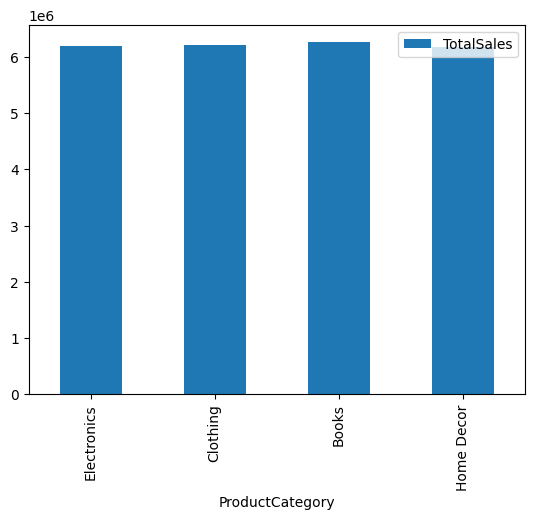

In [36]:
# Gráfico de barras de vendas por categoria
Transaction_Agrupado.plot(kind='bar', x='ProductCategory', y='TotalSales')
plt.title('Total de Vendas por Categoria de Produto')
plt.show()

AttributeError: module 'matplotlib' has no attribute 'title'

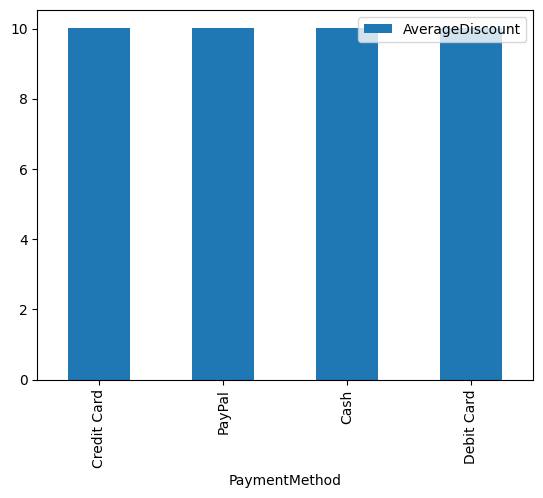

In [37]:
# Gráfico de barras de desconto médio por método de pagamento
Transaction_Descontos.plot(kind='bar', x='PaymentMethod', y='AverageDiscount')
plt.title('Desconto Médio por Método de Pagamento')
plt.show()

In [38]:
# Gráfico de linhas de vendas mensais
Transaction_venda_mensal.plot(kind='line', x=['Year', 'Month'], y='MonthlySales')
plt.title('Vendas Mensais')
plt.show()

ValueError: x must be a label or position

In [39]:
sns.set(style="whitegrid")

# Plotar distribuição antes e depois da remoção de outliers
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Distribuição sem outliers
sns.histplot(outliers["TotalAmount"], bins=30, kde=True, ax=axes[1])
axes[1].set_title('Distribuição Sem Outliers')

plt.tight_layout()
plt.show()

AttributeError: module 'matplotlib' has no attribute 'subplots'

In [ ]:
spark.stop()